# Fitbit Activity Data - Making Predictions with Machine Learning

After exploring the data in a previous post, it's time to see if knowing past health data can help to predict how I will perform or behave in the future. First we'll make an attempt at some simple predictions of general activity (as measured by daily steps), then move on to predicting jogging metrics (such as pace, distance).

Included: 
* Linear Regression
* Fixed Effects Regression
* Stepwise Regression (with cross-validation)
* Assessing variable influence (Added Variable Plots)

But, to begin, we have to load our data and libraries.

If we desire to be able to predict the pace at which I might run or steps I will take in the future we'll need our data to be lagged. Inputting data from the same day as the answer won't give a generalizable model, so we need to have data from the past available for our model. To save time, I previously created variables for key data, segmenting them out to yesterday and moving averages (7 day, 14 day, 30 day, etc.).

In [1]:
#setwd('E:/Fitbit')

# function to quietly load packages
load_quietly <- function(package) { 
  suppressWarnings(suppressMessages(library(deparse(substitute(package)), character.only=TRUE))) 
}

options(scipen=999) # turns-off scientific notation

#library(tidyr, lib='E:/Fitbit')
load_quietly(tidyverse)
load_quietly(magrittr)
load_quietly(zoo)
load_quietly(readr)
load_quietly(xts)
theme_set(theme_classic())

fitbit = read.csv('Data/fitbit_v2.csv') %>% select(-X)

# 1. Predicting Activity from Sleep Data

What is the impact of yesterday's sleep on today's activity?

### Simple Linear Regression

In [2]:
load_quietly(sjPlot)
load_quietly(stargazer)
fitbit %<>% mutate(YesterdaySleep = lag(HrsAsleep, n=1)) # create lagged sleep variable with yesterday's hours of sleep
mod.sleep = lm(Steps ~ YesterdaySleep, data=fitbit)
summary(mod.sleep)
stargazer(mod.sleep, type='text')

ERROR: Error: package or namespace load failed for ‘sjPlot’:
 object ‘format_p’ is not exported by 'namespace:insight'


The amount of sleep I get the night before a run is a significant predictor of my activity the next day (p<.001). However, the effect is relatively small (for every extra hour of sleep I walk only 364 less steps, on average). Looking at a plot of the impact across different levels of sleep it is evident that the effect of sleep is null for most possible sleep hours (the areas where the blue line is within the red region indicate null impact).

However, it is important to note the direction of the coefficient and the slope of the graph above the recommended 8 or so hours of sleep. When I get above the recommended amount, my total number of steps typically decline. I suspect much of this has to do with weekends, as they are when I typically catch up on sleep and get the least amount of exercise. Thus, before putting too much stock in extra sleep harming exercise I would want to include this potential lurking variable (day of week).

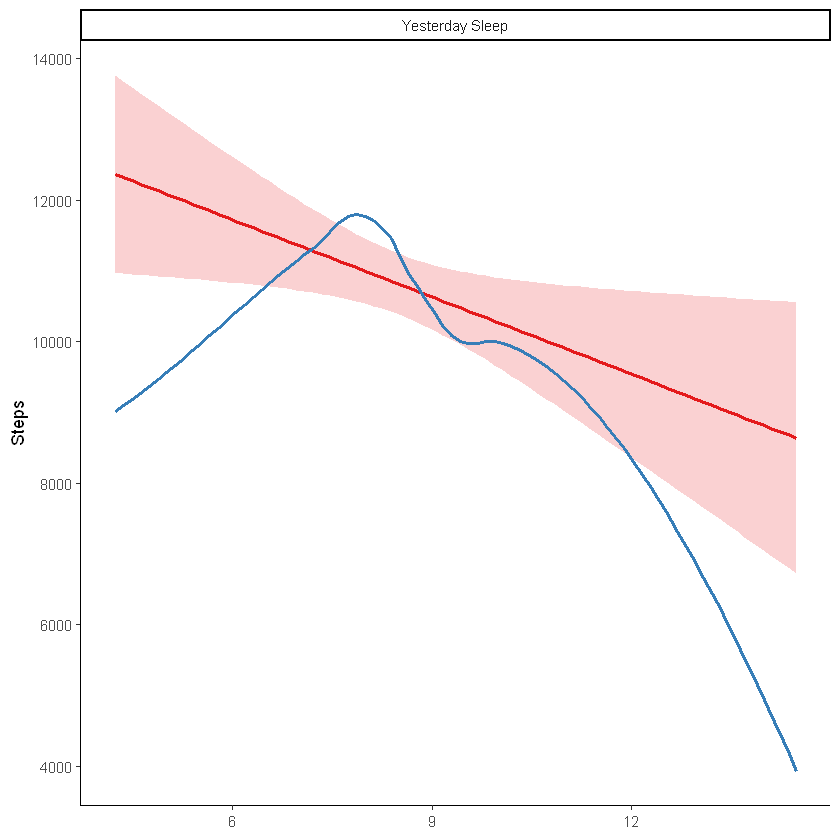

In [4]:
plot_model(mod.sleep)

### Fixed Effects Regression

To analyze our suspected lurking variable (day of the week), we can run a simple fixed effects model for estimating the relation between steps, heart rate, and day of the week, represented by the following equation:

\begin{align}
Steps_{it} = \beta_1 YesterdayRestingHR_{it} + DayofWeekFixedEffects + u_{it}, \
\end{align}

By including day fixed effects, we eliminate the risk of bias due to omitted factors that vary across days, a bias we suspect from looking at the general daily trends in the exploratory analysis conducted previously. (https://www.econometrics-with-r.org/10-3-fixed-effects-regression.html)

In [5]:
mod.sleepday = lm(Steps ~ YesterdaySleep + Day -1, data=fitbit)
summary(mod.sleepday)
stargazer(mod.sleepday, type='text')


Call:
lm(formula = Steps ~ YesterdaySleep + Day - 1, data = fitbit)

Residuals:
     Min       1Q   Median       3Q      Max 
-12145.4  -2816.1    141.8   2651.8  14169.7 

Coefficients:
               Estimate Std. Error t value             Pr(>|t|)    
YesterdaySleep   -214.3      158.3  -1.354                0.177    
DayFriday       14460.7     1446.1  10.000 < 0.0000000000000002 ***
DayMonday       12662.4     1535.5   8.246  0.00000000000000259 ***
DaySaturday     10146.2     1424.6   7.122  0.00000000000523155 ***
DaySunday       10377.3     1560.7   6.649  0.00000000010101053 ***
DayThursday     13379.9     1420.5   9.419 < 0.0000000000000002 ***
DayTuesday      14029.4     1412.1   9.935 < 0.0000000000000002 ***
DayWednesday    13245.6     1371.1   9.660 < 0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4107 on 386 degrees of freedom
  (233 observations deleted due to missingness)
Multiple R-squared:  0.8786,


                        Dependent variable:    
                    ---------------------------
                               Steps           
-----------------------------------------------
YesterdaySleep               -214.327          
                             (158.343)         
                                               
DayFriday                  14,460.720***       
                            (1,446.092)        
                                               
DayMonday                  12,662.410***       
                            (1,535.502)        
                                               
DaySaturday                10,146.210***       
                            (1,424.579)        
                                               
DaySunday                  10,377.340***       
                            (1,560.740)        
                                               
DayThursday                13,379.950***       
                            (1,420.543)

Running a fixed effects regression with day of the week we see that the variance in steps previously partially explained by yesterday's sleep is better explained by day of the week. Including day of the week into the model explains far more of the variation in steps (R-squared of .88 vs .01), soaking up the variance previously thought to be due to sleep alone. 

Although the coefficient for yesterday's sleep is no longer significant (p=.18), the direction still indicates that on average more sleep reduces the number of steps taken the next day.

# 2. Predicting Running Pace from Resting Heart Rate

Resting heart rate provides a picture of cardiovascular health, but does a short-term picture of cardiovascular health help predict how fast I run?

### Simple Linear Regression

In [6]:
mod.heart = lm(Pace ~ HRYesterday, data=fitbit)
summary(mod.heart)
stargazer(mod.heart, type='text')


Call:
lm(formula = Pace ~ HRYesterday, data = fitbit)

Residuals:
    Min      1Q  Median      3Q     Max 
-50.768  -5.820   1.652   8.357  38.980 

Coefficients:
            Estimate Std. Error t value             Pr(>|t|)    
(Intercept) 411.7899    20.4633  20.123 < 0.0000000000000002 ***
HRYesterday   1.2440     0.3447   3.608             0.000376 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 13.93 on 236 degrees of freedom
  (389 observations deleted due to missingness)
Multiple R-squared:  0.05229,	Adjusted R-squared:  0.04827 
F-statistic: 13.02 on 1 and 236 DF,  p-value: 0.000376



                        Dependent variable:    
                    ---------------------------
                               Pace            
-----------------------------------------------
HRYesterday                  1.244***          
                              (0.345)          
                                               
Constant                    411.790***         
                             (20.463)          
                                               
-----------------------------------------------
Observations                    238            
R2                             0.052           
Adjusted R2                    0.048           
Residual Std. Error      13.927 (df = 236)     
F Statistic           13.021*** (df = 1; 236)  
Note:               *p<0.1; **p<0.05; ***p<0.01


From the model it appears yesterday's heart rate is a significant predictor of running pace, with an estimated increase of 1.244 seconds of pace (running slower) for every 1 beat per minute higher, on average. However, the effect is small, indicated by a small r-squared value (.05) and significant overlap between the predictor and null effects (blue line most often within the red, null effects region).

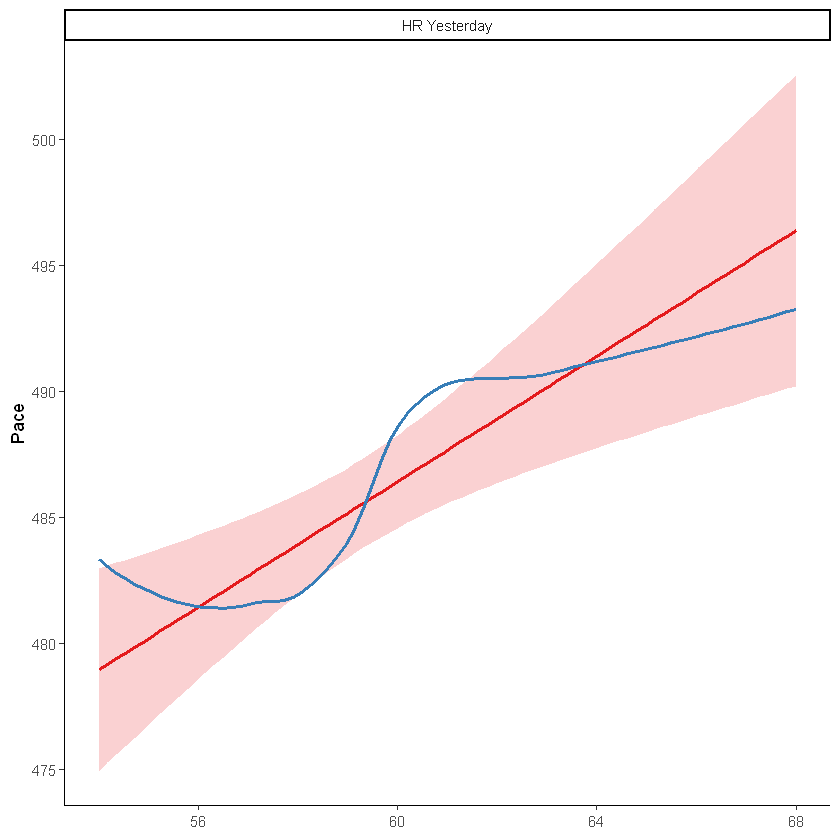

In [7]:
plot_model(mod.heart)

# 3. Predicting Running Speed from Multiple Metrics

To most accurately predict my future performance from past metrics, I'll want to both incorporate logical variables (which should impact how fast one runs) and use these from the most useful time period (recent or rolling averages).

#### Yesterday Versus Rolling Averages

An easy way to check on the usefulness of potential predictors is to see the strength of their relationship with the outcome variable through simple correlations. With a correlation matrix of current and historical data we can quickly get an idea of what time level of data might be the most useful for our models. The following table includes a few potential predictors of resting heart rate and their averages over time.

In [8]:
fitbit %>%
  select(RestHR,AvgHR,floorsYesterday,floors7dayAvg,floors14dayAvg,floors30dayAvg,
         stepsYesterday,steps7dayAvg,steps14dayAvg,steps30dayAvg) -> corpred
mcor = round(cor(corpred, use="complete.obs"),2) 
upper = mcor
upper[upper.tri(mcor)] <- ""
upper = as.data.frame(upper)
upper

,RestHR,AvgHR,floorsYesterday,floors7dayAvg,floors14dayAvg,floors30dayAvg,stepsYesterday,steps7dayAvg,steps14dayAvg,steps30dayAvg
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
RestHR,1,,,,,,,,,
AvgHR,0.01,1,,,,,,,,
floorsYesterday,-0.11,-0.14,1,,,,,,,
floors7dayAvg,-0.54,-0.27,0.38,1,,,,,,
floors14dayAvg,-0.64,-0.29,0.31,0.8,1,,,,,
floors30dayAvg,-0.56,-0.24,0.28,0.67,0.83,1,,,,
stepsYesterday,-0.1,-0.05,0.79,0.34,0.31,0.31,1,,,
steps7dayAvg,-0.46,-0.2,0.24,0.78,0.71,0.64,0.36,1,,
steps14dayAvg,-0.49,-0.23,0.23,0.68,0.85,0.75,0.33,0.83,1,


While these data do not include significance or confidence intervals, it is readily apparent that yesterday has little impact on the resting heart rate of today (both correlations near -.1). It also looks like the moving averages follow a pattern with resting heart rate, especially the seven day average (though this analysis does not reveal whether these differences are significant or whether a different metric, such as five days, would have a stronger relationship).

#### Impact of Weather to Running Speed

Using historical weather data from Dark Sky I have data for the temperature, heat index, humidity, and dew point at the time of each of the 240 runs within the dataset. As these runs occur over the period of nearly two years, they encompass a variety of weather conditions and should be interesting to analyze.

In [9]:
justruns = fitbit %>% filter(Distance >1) # create subset of data with just running data
load_quietly(psych)
justruns %>% 
    select(Temp,HeatIndex,Humidity,DewPoint) %>% 
    describe(.) %>% 
    select(n,mean,median,sd,max)

,n,mean,median,sd,max
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Temp,240,76.48333,78.5,12.16586,98
HeatIndex,240,78.48750,79.0,14.10836,103
Humidity,240,62.44167,64.0,21.28126,95
DewPoint,240,60.82500,65.5,13.67046,77


In [10]:
mod.weather = lm(speed ~ Temp + HeatIndex + Humidity + DewPoint, data=justruns)
summary(mod.weather)


Call:
lm(formula = speed ~ Temp + HeatIndex + Humidity + DewPoint, 
    data = justruns)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.43622 -0.13229 -0.04168  0.08302  0.82869 

Coefficients:
             Estimate Std. Error t value            Pr(>|t|)    
(Intercept)  7.131994   0.323308  22.059 <0.0000000000000002 ***
Temp        -0.007327   0.009438  -0.776              0.4383    
HeatIndex    0.012939   0.008005   1.616              0.1073    
Humidity     0.008000   0.003657   2.188              0.0297 *  
DewPoint    -0.010974   0.007131  -1.539              0.1252    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2137 on 235 degrees of freedom
Multiple R-squared:  0.1318,	Adjusted R-squared:  0.117 
F-statistic: 8.921 on 4 and 235 DF,  p-value: 0.000001008


Weather by itself does not appear to be too useful in predicting running speed (though humidity is a significant predictor in our basic weather model, with speed predicted to increase a tiny bit as humidity increases). Instead of this piecemeal approach of choosing predictors, perhaps some math can help us indentify useful variables.

### Stepwise Regression

To select features I'll run a stepwise regression, iterating over all of the available running variables, choosing the combintation of variables which produces the lowest error (RMSE) and/or highest amount of variance explained (adjusted r-squared). I'll include cross-validation with 10 folds to make the model more generalizable/avoid over fitting. The caret package in R will do this for us by repeatedly training a model on slightly different subsets (folds), then averaging their performance together to come to the final model.

Variables: I've combed through the dataset and chosen a list of 19 which logically could have a significant impact on running speed.

* weather-related variables (temperature, heat index, humidity, dew point)
* running-related variables (distance, elevation gain)
* recent health-related variables (floors climbed yesterday, average number of floors climbed in last week, last two weeks, and last 30 days; steps walked yesterday, average number of steps walked in last week, two weeks, and last 30 days; resting heart rate yesterday, average resting heart rate over past week, two weeks, and 30 days)
* recent sleep-related variables (yesterday's hours of sleep)

In [11]:
features = justruns %>% select(speed, Temp, HeatIndex, Humidity, DewPoint, floorsYesterday, floors7dayAvg, floors14dayAvg, 
                               floors30dayAvg, stepsYesterday, steps7dayAvg, steps14dayAvg, steps30dayAvg, HRYesterday,
                               HR7dayAvg, HR14dayAvg, HR30dayAvg, Distance, ElevGain, YesterdaySleep) %>% drop_na()

load_quietly(caret)
set.seed(123) # Set seed for reproducibility
train.control <- trainControl(method = "cv", number = 10) # Set up repeated k-fold cross-validation
step.model <- train(speed ~., data = features,
                    method = "leapBackward", 
                    tuneGrid = data.frame(nvmax = 1:19), # max at full model with all variables
                    trControl = train.control
)

step.model$results

nvmax,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.1621955,0.2055543,0.1349588,0.03344210,0.20299118,0.02443310
2,0.1470034,0.4098206,0.1151272,0.02194000,0.13800653,0.01621873
3,0.1411776,0.4475760,0.1103848,0.02513490,0.08437149,0.01880494
4,0.1349562,0.5027334,0.1080666,0.02357031,0.14221796,0.01650210
5,0.1321796,0.5106139,0.1046966,0.02115325,0.12335641,0.01431410
6,0.1312729,0.5324967,0.1039640,0.02074524,0.12217208,0.01467702
7,0.1302105,0.5370769,0.1025030,0.01996122,0.11367121,0.01216149
8,0.1301828,0.5334489,0.1017452,0.02075734,0.11298256,0.01317397
9,0.1281383,0.5328630,0.1009189,0.02033168,0.11878782,0.01237276


Our stepwise regression model indicates a nine variable model of the data produces the highest r-squared (.53) / lowest RMSE (.13), as the error increases with additional/different variables included.

In [12]:
summary(step.model$finalModel)

Subset selection object
19 Variables  (and intercept)
                Forced in Forced out
Temp                FALSE      FALSE
HeatIndex           FALSE      FALSE
Humidity            FALSE      FALSE
DewPoint            FALSE      FALSE
floorsYesterday     FALSE      FALSE
floors7dayAvg       FALSE      FALSE
floors14dayAvg      FALSE      FALSE
floors30dayAvg      FALSE      FALSE
stepsYesterday      FALSE      FALSE
steps7dayAvg        FALSE      FALSE
steps14dayAvg       FALSE      FALSE
steps30dayAvg       FALSE      FALSE
HRYesterday         FALSE      FALSE
HR7dayAvg           FALSE      FALSE
HR14dayAvg          FALSE      FALSE
HR30dayAvg          FALSE      FALSE
Distance            FALSE      FALSE
ElevGain            FALSE      FALSE
YesterdaySleep      FALSE      FALSE
1 subsets of each size up to 9
Selection Algorithm: backward
         Temp HeatIndex Humidity DewPoint floorsYesterday floors7dayAvg
1  ( 1 ) " "  " "       " "      " "      " "             " "          
2

#### Check impact of each predictor to outcome

Which predictors are significant and what are the estimated effect sizes (coefficients)?

In [13]:
load_quietly(car)
load_quietly(xtable)
step.chosen = glm(speed ~ HeatIndex + Humidity + floorsYesterday + floors30dayAvg + steps14dayAvg + HRYesterday + 
                 HR30dayAvg + Distance + ElevGain, data = features)
xtable(step.chosen)

,Estimate,Std. Error,t value,Pr(>|t|)
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.62080213797,0.71923660861,5.034229,0.0000017744722503
HeatIndex,0.00194060685,0.00106148878,1.828193,0.0700901506463167
Humidity,0.00167607498,0.00057330219,2.923545,0.0041622650213005
floorsYesterday,-0.00185346407,0.00078917779,-2.348601,0.0205364097146576
floors30dayAvg,0.01329982004,0.00406508021,3.271724,0.0014082104243884
steps14dayAvg,0.00004039429,0.00001405086,2.874863,0.0048099471239197
HRYesterday,-0.01655096278,0.00595385830,-2.779872,0.0063465647480400
HR30dayAvg,0.06364084898,0.00939219893,6.775926,0.0000000005417374
Distance,0.06716301736,0.04800017700,1.399224,0.1644140396605326


Two variables were included in the model as they help to explain overall variation in running speed when included with the others, though independently are not significant predictors (Heat Index, p=.07 and Distance, p=.16). The other seven were each significant predictors and their impact to running speed can better be seen through added variable plots.

#### Added Variable Plots

Added variable plots depict the relationship between the predictor (x) and the outcome (y), holding all of the other variables constant. Also known as partial-regression leverage plots, these visuals reveal both the residuals and coefficients of the predictor variables in a multiple regression. The strength and direction can be seen in the slope (larger movements in the slope indicate stronger effects) and because the impact of other variables are accounted for in the plots, concerns about multicollinearity and cross-effects are reduced.

All nine plots provide a quick overview, though we'll focus in on a few of them in greater depth below.

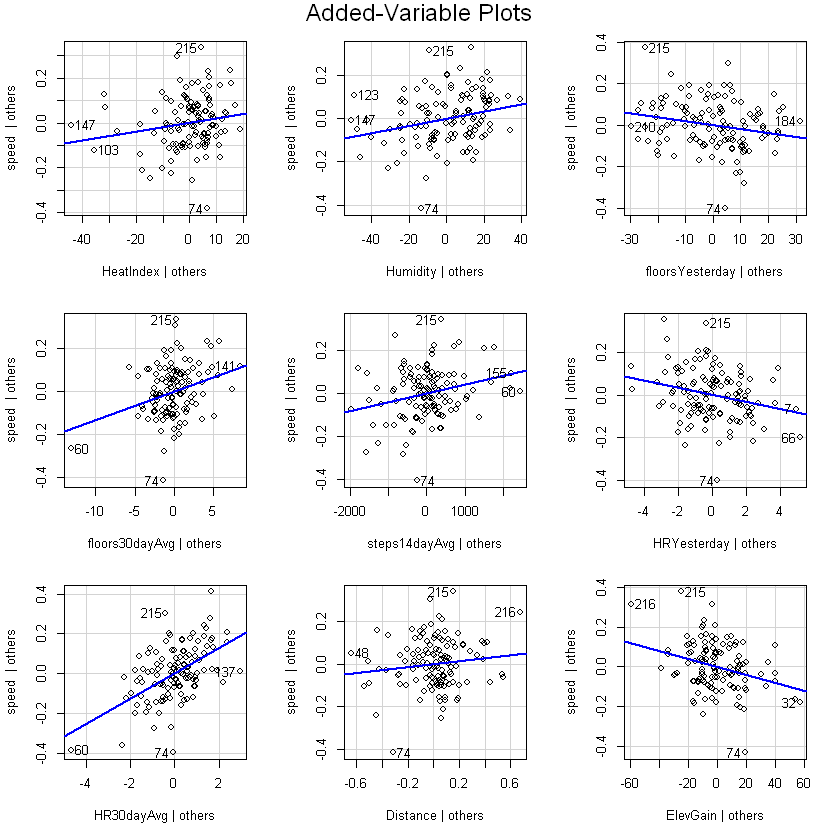

In [14]:
avPlots(step.chosen)

One of the steepest slopes, and thus strongest effects, is clearly the 30 day resting heart rate average. As my monthly resting heart rate increases, my speed (in mph) increases. This effect seems counterintuitive. I would have presumed that with a lower average resting heart rate I would be in better shape, and thus run faster (as the model controls for confounding variables such as distance and elevation gain). I'll have to ponder this one some more!

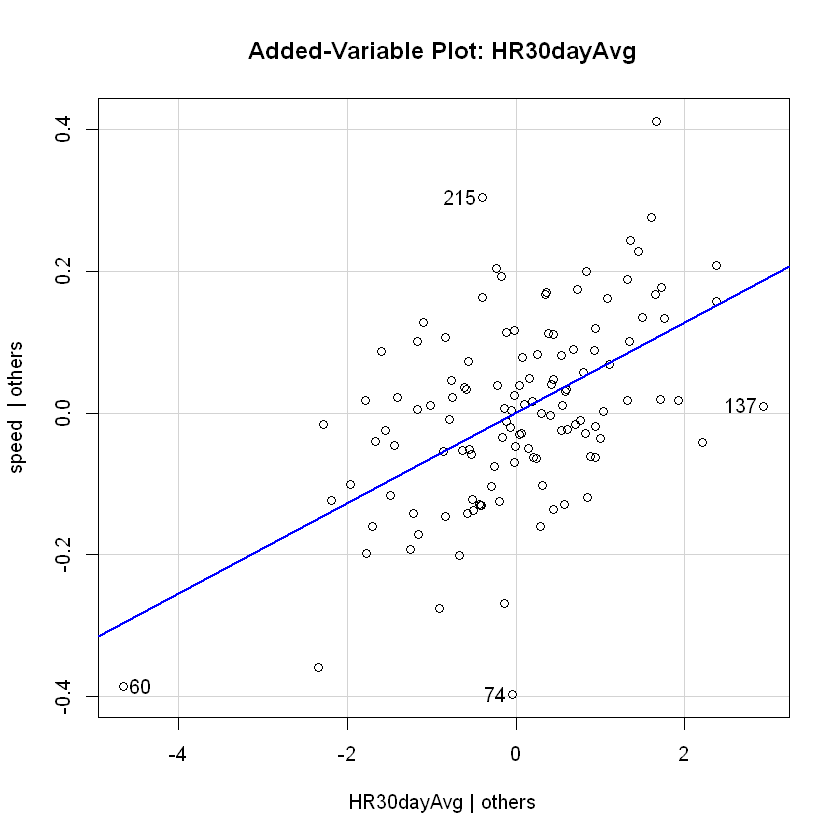

In [15]:
avPlot(step.chosen, "HR30dayAvg")

While it may seem like cheating to incorporate variables for the current run into a predictive model, if one knows how far they will be running, and the elevation gain which will be encountered, including these in the model will help to more accurately predict the speed of the run.

As elevation increases, my running speed slows down, as would be expected. However, distance is a bit more complicated. The model predicts that as distance increases, so does my speed, though distance is not a significant predictor in the model (p=.16). My runs throughout this dataset are often of the same distance (around 2 to 2.5 miles). Only when I am in better shape do I run longer than this, which also means I likely run at a greater speed, which might help to explain the direction of the non-significant effect of distance.

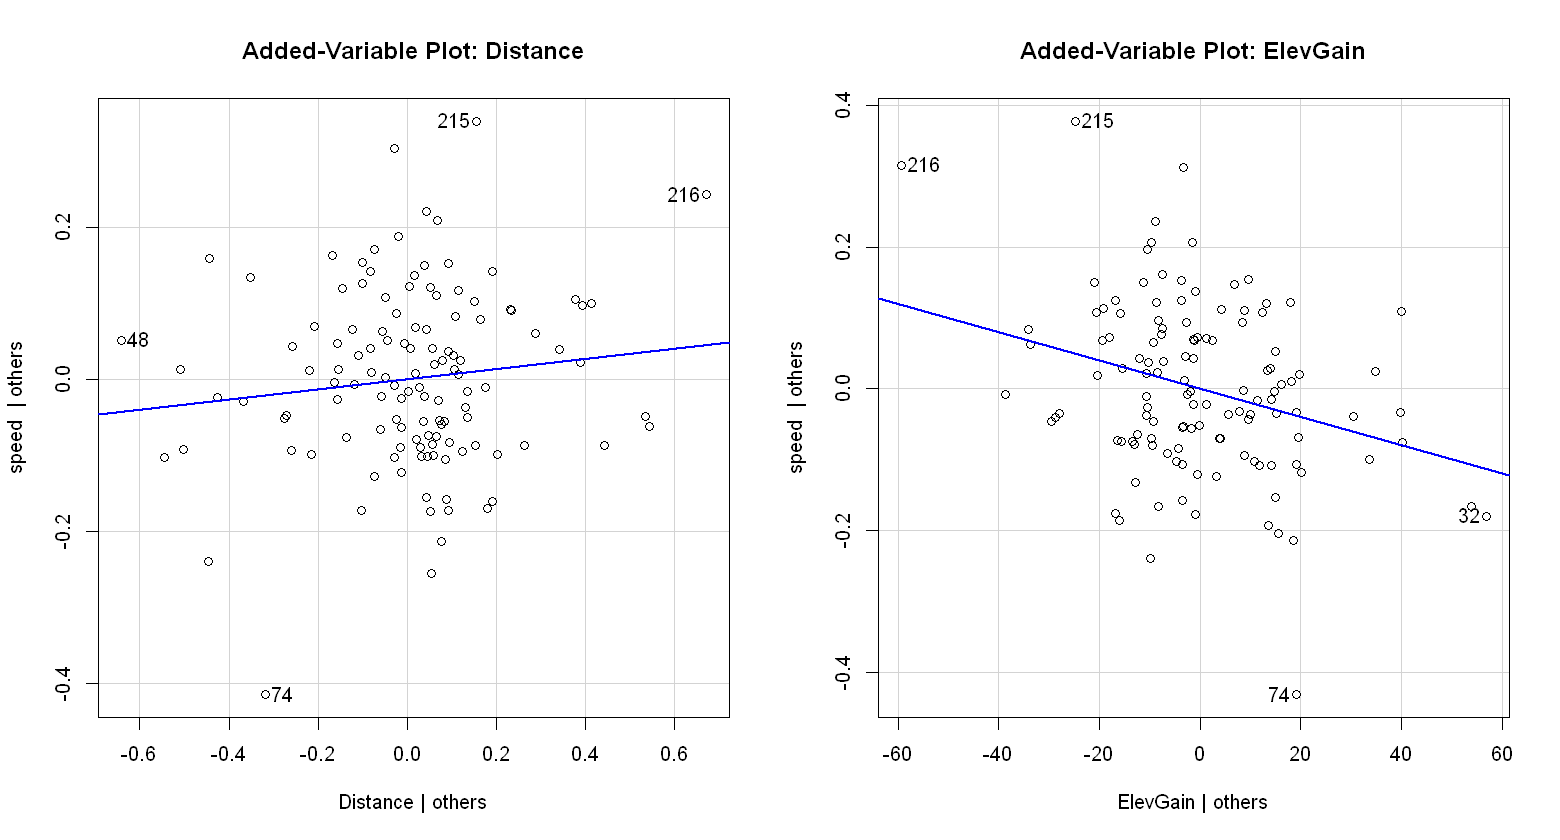

In [16]:
library(repr)
options(repr.plot.width=13, repr.plot.height=7) # Change plot size
par(mfrow=c(1,2)) # plot together
avPlot(step.chosen, "Distance")
avPlot(step.chosen, "ElevGain")

Though both heat index and humidity have smaller effect sizes than my heart rate and monthly floors climbed averages, they still have a significant impact on my running speed. For both metrics, as they increase, so does my running speed. Some like it hot and humid, I guess!

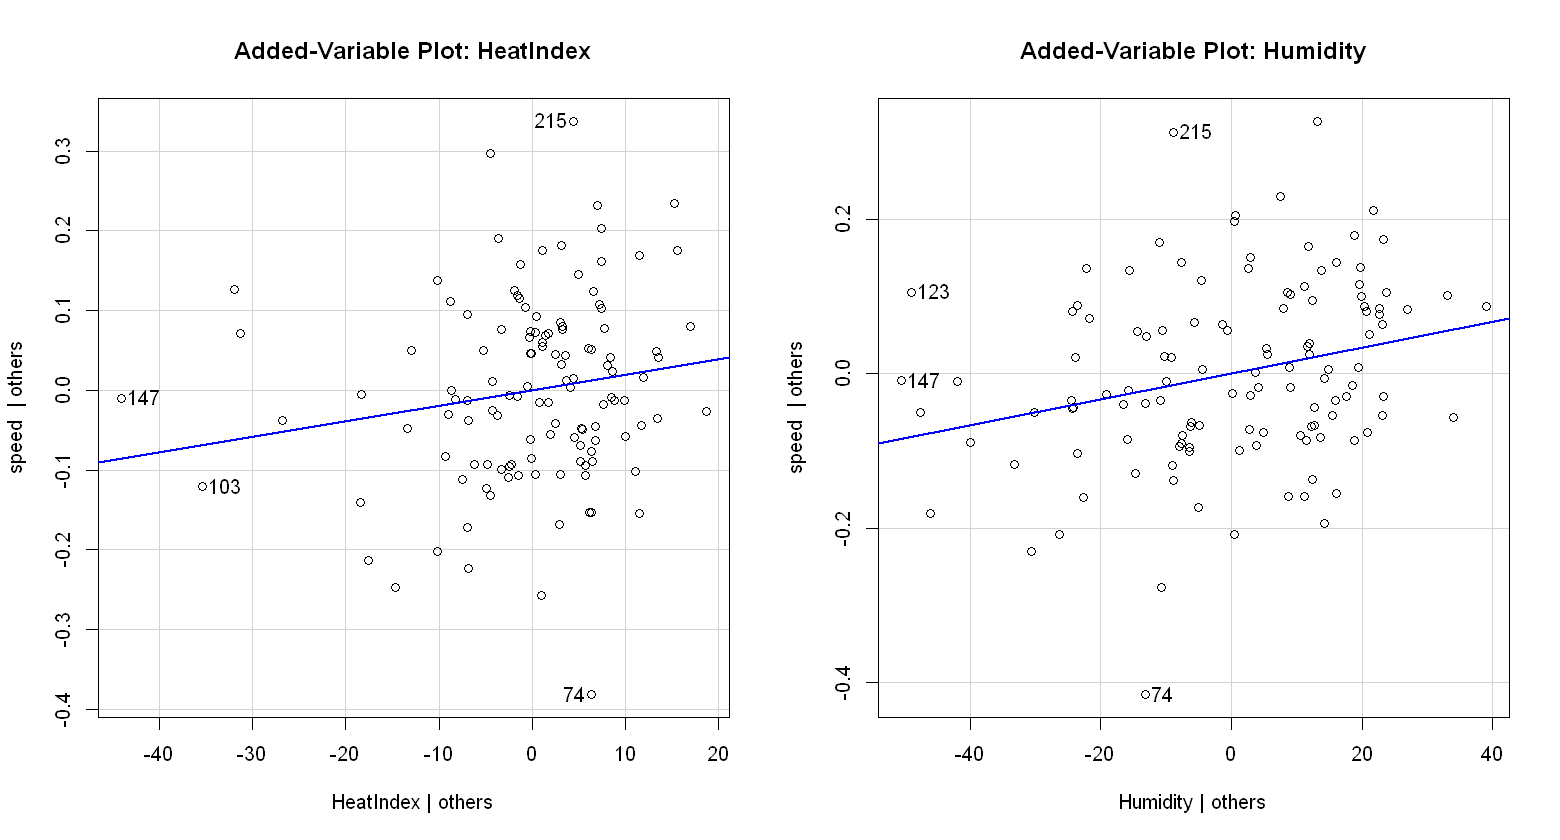

In [17]:
par(mfrow=c(1,2)) # plot together
avPlot(step.chosen, "HeatIndex")
avPlot(step.chosen, "Humidity")

Both the floors climbed in the previous day and the average over the past 30 days were chosen in the model: I guess getting vertical is important for running speed! Interestingly, the variables affect my running speed in opposite ways. 

The more floors I climbed yesterday, the slower I run the next day (though the impact is minimal at .001 mph/floor).

Of a much greater impact is my monthly floor climbing history, with every floor averaged over the past 30 days increasing my speed by .013 mph, on average. Don't take that elevator at work!

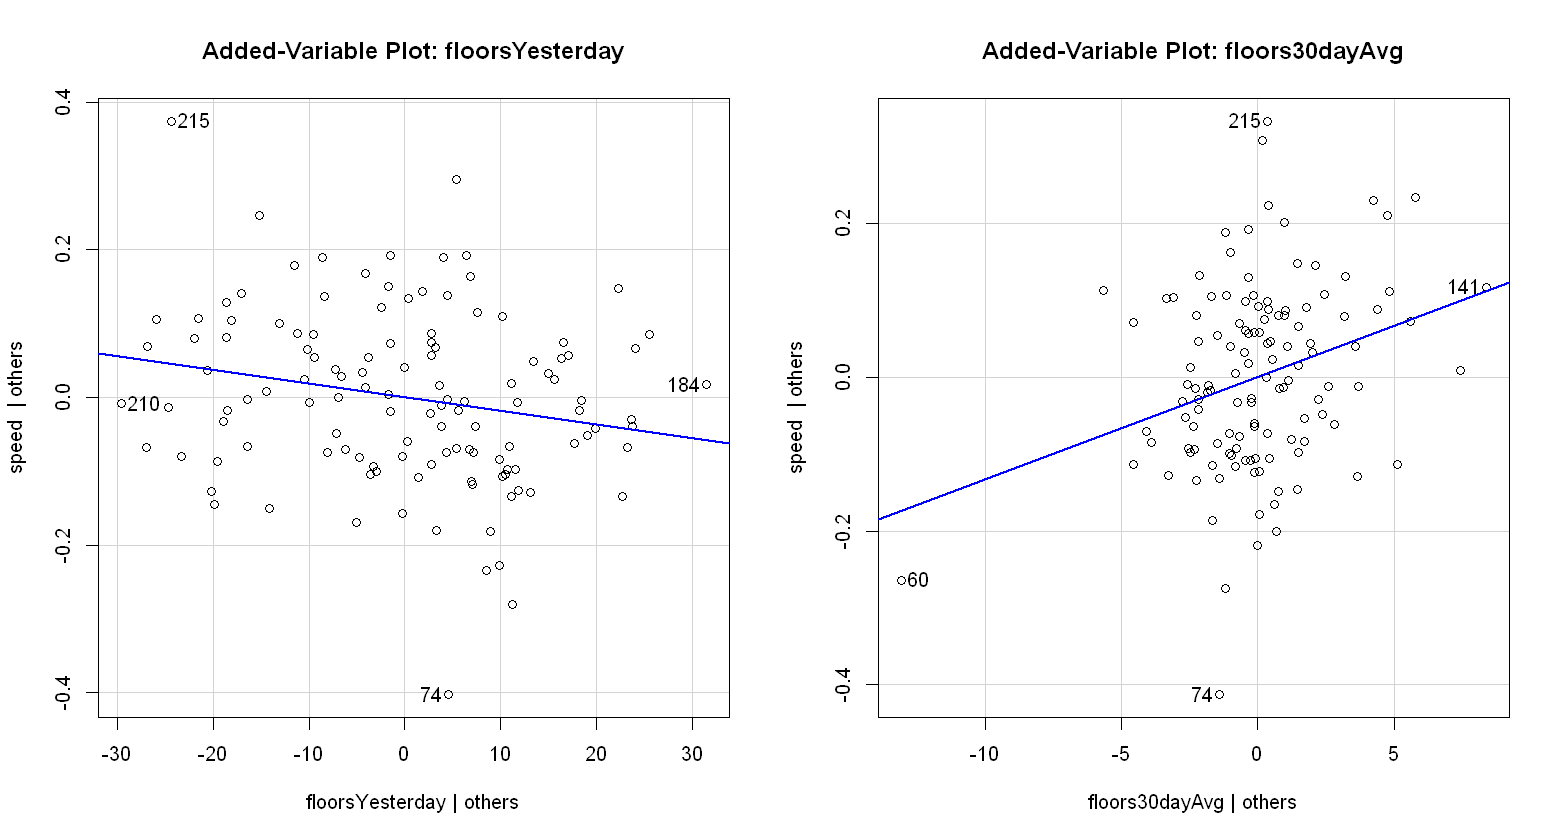

In [18]:
par(mfrow=c(1,2)) # plot together
avPlot(step.chosen, "floorsYesterday")
avPlot(step.chosen, "floors30dayAvg")

## Conclusions and Future Directions

With a model that can predict 53% of the variability in my running speed from data easily gathered from my Fitbit, the weather, and where I plan to run, I am off to a pretty good start. However, I think I can capture even more of the variance in running speed with a few more data points. I believe the model would improve with access to other explanatory variables of running speed, such as:

* My current weight
* Hours since I last ate (digestion)
* Wind speed (or some measure of the impact of wind to the run)
* Number of workouts in the past week, month (exhaustion)

I've started measuring my weight on a daily basis and will consider gathering data on additional variables, as well. Look for a potential update in the future!